## Setting Up:

In [2]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import zipfile
import cdsapi
import numpy as np
import glob
import xarray as xr

from scripts.config_NOR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Download monthly ERA5-Land variables:

To download ERA5-Land data you need to configure your API client first. For this, follow these instructions: https://forum.ecmwf.int/t/step-by-step-instructions-on-how-to-download-data-using-new-climate-data-store-beta-cds-beta/3743. 

To summarize instructions: 
- Your existing CDS credentials will not work in CDS-Beta, you need to have an ECMWF account - register one here: https://www.ecmwf.int/. 
- Once you have set up an account, make sure that you accepted licences in the Download form of the product page: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=download. 
- Make sure that you are logged in ECMWF then navigate to the CDSAPI setup page to copy the content for your .cdsapirc file: https://cds.climate.copernicus.eu/how-to-api. 

Once this is set up, you should be able to download the ERA5-Land data using our script. 

In [ ]:
RUN = True
if RUN:
    os.makedirs(path_ERA5_raw, exist_ok=True)
    c = cdsapi.Client()

    # climate variables
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            'product_type': ['monthly_averaged_reanalysis'],
            'variable': [
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation',
            ],
            'year': [
                '1950',
                '1951',
                '1952',
                '1953',
                '1954',
                '1955',
                '1956',
                '1957',
                '1958',
                '1959',
                '1960',
                '1961',
                '1962',
                '1963',
                '1964',
                '1965',
                '1966',
                '1967',
                '1968',
                '1969',
                '1970',
                '1971',
                '1972',
                '1973',
                '1974',
                '1975',
                '1976',
                '1977',
                '1978',
                '1979',
                '1980',
                '1981',
                '1982',
                '1983',
                '1984',
                '1985',
                '1986',
                '1987',
                '1988',
                '1989',
                '1990',
                '1991',
                '1992',
                '1993',
                '1994',
                '1995',
                '1996',
                '1997',
                '1998',
                '1999',
                '2000',
                '2001',
                '2002',
                '2003',
                '2004',
                '2005',
                '2006',
                '2007',
                '2008',
                '2009',
                '2010',
                '2011',
                '2012',
                '2013',
                '2014',
                '2015',
                '2016',
                '2017',
                '2018',
                '2019',
                '2020',
                '2021',
                '2022',
                '2023',
                '2024',
            ],
            'month': [
                '01',
                '02',
                '03',
                '04',
                '05',
                '06',
                '07',
                '08',
                '09',
                '10',
                '11',
                '12',
            ],
            'time': ['00:00'],
            "data_format":
            "netcdf",
            "download_format":
            "zip",
            'area': [   # Norway and Switerland
                72,    # North latitude
                0,     # West longitude
                42,    # South latitude
                32,    # East longitude
            ]
        }, path_ERA5_raw + 'download.netcdf.zip')
    with zipfile.ZipFile(path_ERA5_raw + 'download.netcdf.zip', 'r') as zip:
        zip.extractall(path_ERA5_raw)

    # geopotential pressure (old too low resolution)
    # c.retrieve(
    #     "reanalysis-era5-single-levels", {
    #         "product_type": ["reanalysis"],
    #         "variable": ["geopotential"],
    #         "year": ["2024"],
    #         "month": ["06"],
    #         "day": ["01"],
    #         "time": ["12:00"],
    #         "data_format": "netcdf",
    #         'area': [
    #             50,
    #             0,
    #             45,
    #             20,
    #         ]
    #     }, path_ERA5_raw + 'era5_geopotential_pressure.nc')
    
    # geopot from era5-land reanalysis directly (new product with better resolution)
    # download it separately so that the pipeline still works
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            "variable": ["geopotential"],
            "data_format": "netcdf",
            "download_format": "zip",
            'area': [  # Norway and Switerland 
                72,    # North latitude
                0,     # West longitude
                42,    # South latitude
                32,    # East longitude
            ]
        }, path_ERA5_raw + 'download_geopot.netcdf.zip')
    with zipfile.ZipFile(path_ERA5_raw + 'download_geopot.netcdf.zip', 'r') as zip:
        zip.extractall(path_ERA5_raw)

"""
NORWAY
'area': [
                72,    # North latitude
                4,     # West longitude
                57,    # South latitude
                32,    # East longitude
            ]
"""

In [7]:
! ls "{path_ERA5_raw}"

data_stream-moda.nc  geo.area-subset.72.32.42.0.nc


In [ ]:
# Correct era5 data
dc = xr.open_dataset(path_ERA5_raw + 'data_stream-moda.nc')
dc2 = dc.rename(
    {'valid_time': 'time'}
)  # Coordinates have changed recently in the API, this is to keep compatibility with our code

# delete file if already exists
if os.path.exists(path_ERA5_raw + 'era5_monthly_averaged_data.nc'):
    os.remove(path_ERA5_raw + 'era5_monthly_averaged_data.nc')
dc2.to_netcdf(path_ERA5_raw + "era5_monthly_averaged_data.nc")

# change name of geopotential file: 
dc = xr.open_dataset(path_ERA5_raw + 'geo.area-subset.72.32.42.0.nc')
# delete file if already exists
if os.path.exists(path_ERA5_raw + 'era5_geopotential_pressure.nc'):
    os.remove(path_ERA5_raw + 'era5_geopotential_pressure.nc')
dc.to_netcdf(path_ERA5_raw + "era5_geopotential_pressure.nc")

# delete old files
os.remove(path_ERA5_raw + 'download.netcdf.zip')
os.remove(path_ERA5_raw + 'data_stream-moda.nc')
os.remove(path_ERA5_raw+'download_geopot.netcdf.zip')
os.remove(path_ERA5_raw+'geo.area-subset.72.32.42.0.nc')

In [11]:
! ls "{path_ERA5_raw}"

data_stream-moda.nc	       era5_monthly_averaged_data.nc
era5_geopotential_pressure.nc  geo.area-subset.72.32.42.0.nc


### Check geopotential data:

In [ ]:
geopot_era5 = xr.open_dataset(path_ERA5_raw + 'era5_geopotential_pressure.nc')
display(geopot_era5)

display(xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc'))

(array([   48232.,   686435.,  2834225.,  6319191., 10560781., 11063859.,
        10602672., 10974891.,  3246794.,   164920.]),
 array([248.45567322, 253.91410828, 259.37255859, 264.83099365,
        270.28942871, 275.74786377, 281.20629883, 286.66473389,
        292.12316895, 297.581604  , 303.04003906]),
 <BarContainer object of 10 artists>)

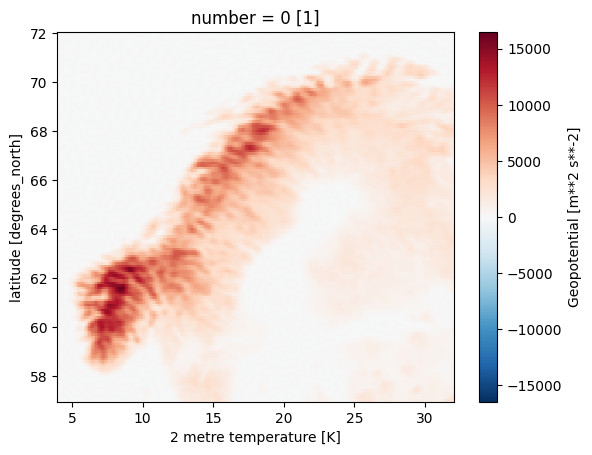

In [ ]:
# plot geopot
geopot_era5.z.plot()

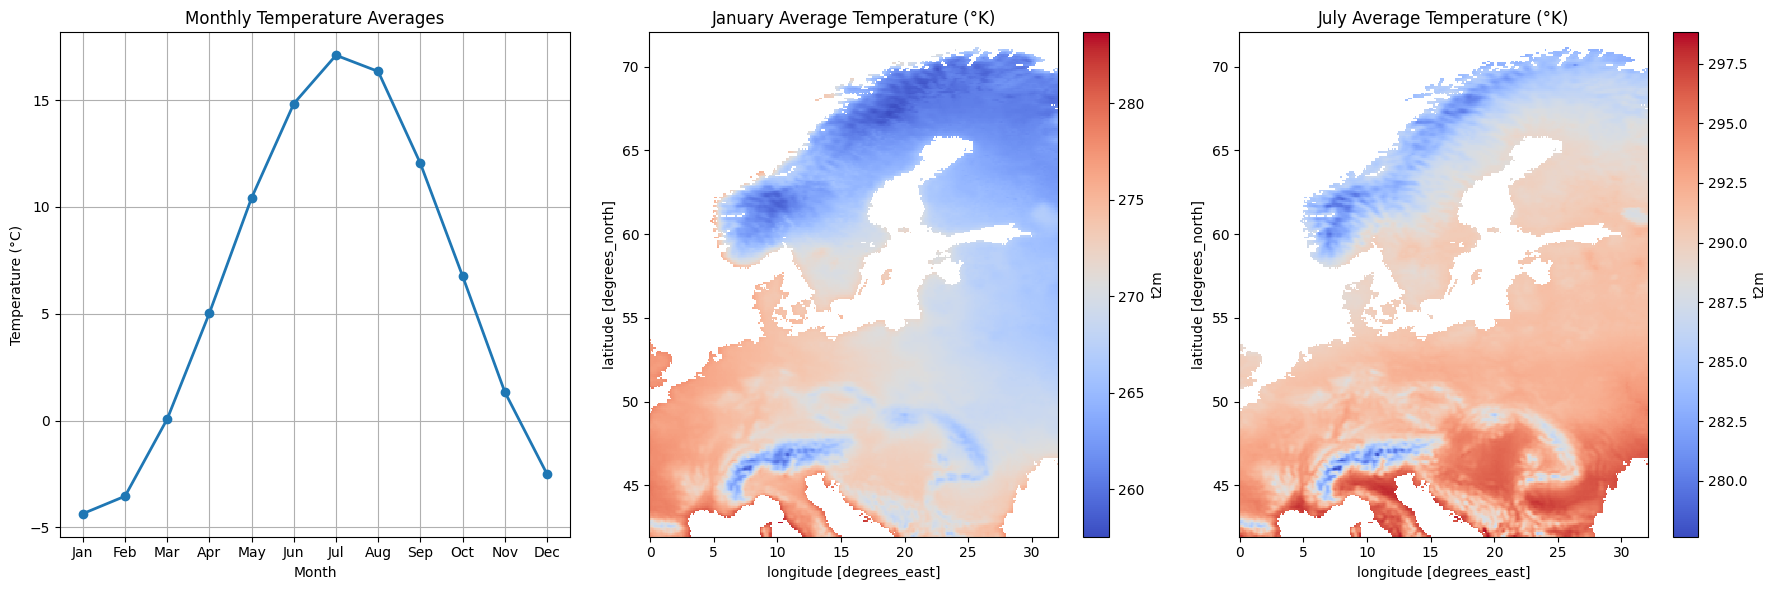


Temperature Validation:
January mean: 268.8°C
July mean: 290.3°C
Annual range: 21.5°C correct


In [ ]:
import matplotlib.pyplot as plt

ds = xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')
temp_var = 't2m'

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Monthly temperature averages
times = pd.to_datetime(ds.time.values)
months = [t.month for t in times]

# Group by month
month_groups = {m: [] for m in range(1, 13)}
for i, m in enumerate(months):
    month_groups[m].append(i)

# Calculate monthly means
monthly_means = []
for m in range(1, 13):
    if month_groups[m]:
        mean_temp = ds[temp_var].isel(time=month_groups[m]).mean().values
        if hasattr(ds[temp_var], 'units') and ds[temp_var].units == 'K':
            mean_temp -= 273.15
        monthly_means.append(float(mean_temp))
    else:
        monthly_means.append(np.nan)

# Plot monthly averages
axs[0].plot(range(1, 13), monthly_means, 'o-', color='#1f77b4', linewidth=2)
axs[0].set_title('Monthly Temperature Averages')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Temperature (°C)')
axs[0].grid(True)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axs[0].set_xticks(range(1, 13))
axs[0].set_xticklabels(month_names)

# 2. January temperature map
jan_indices = [i for i, t in enumerate(times) if t.month == 1]
if jan_indices:
    jan_temp = ds[temp_var].isel(time=jan_indices).mean(dim='time')
    if hasattr(jan_temp, 'units') and jan_temp.units == 'K':
        jan_temp -= 273.15
    jan_temp.plot(ax=axs[1], cmap='coolwarm')
    axs[1].set_title('January Average Temperature (°K)')

# 3. July temperature map
jul_indices = [i for i, t in enumerate(times) if t.month == 7]
if jul_indices:
    jul_temp = ds[temp_var].isel(time=jul_indices).mean(dim='time')
    if hasattr(jul_temp, 'units') and jul_temp.units == 'K':
        jul_temp -= 273.15
    jul_temp.plot(ax=axs[2], cmap='coolwarm')
    axs[2].set_title('July Average Temperature (°K)')

plt.tight_layout()
plt.show()